# Walk around the Fort

Strava collects data from athletes regarding their activities - such as running, cycling, walking and hiking. Members can upload data - and tens of millions do so, including some well known cyclists. I have recorded a walk around the fort with a colleague as a Strava activity.

All details for this activity can be retrieved using: https://www.strava.com/activities/2693790029/streams?stream_types%5B%5D=time&stream_types%5B%5D=velocity_smooth&stream_types%5B%5D=watts_calc&stream_types%5B%5D=altitude&stream_types%5B%5D=heartrate&stream_types%5B%5D=cadence&stream_types%5B%5D=temp&stream_types%5B%5D=distance&stream_types%5B%5D=latlng&stream_types%5B%5D=grade_smooth&_=1565273406470

Note: I do not know yet the meaning or even relevance of the last parameter.
Note 2: these URLs can only be accessed from an authenticated session (authenticated in a browser with a valid Strava account).

I have extracted the data and stored in the file walk-around-the-fort.json.


# Read Data into Pandas
Let's load the JSON data from file into a Pandas Data Frame - just like we almost always do with data to analyze in a Python based Jupyter Notebook. Then we can inspect, wrangle and explore the data set and start preparing for visualization and further processing.

In [75]:
import pandas as pd
import json

def readData(filename):
    s = pd.read_json(filename)
    # calculate speed in km/h
    s['speed']= s['velocity_smooth']*3.6
    s['lat']=s['latlng'].apply(lambda ll: ll[0])
    s['long']=s['latlng'].apply(lambda ll: ll[1])
    return s

s = readData("walk-around-the-fort.json")
s.head(10)

,altitude,latlng,velocity_smooth,grade_smooth,distance,time,speed,lat,long
0,2.6,"[52.033722, 5.09888]",0.0,2.3,0.0,0,0.00,52.033722,5.098880
1,2.8,"[52.033854, 5.098836]",1.2,1.8,8.7,7,4.32,52.033854,5.098836
2,2.9,"[52.033887, 5.098811]",1.3,1.4,12.8,10,4.68,52.033887,5.098811
3,2.9,"[52.033916, 5.09878]",1.3,1.2,16.7,13,4.68,52.033916,5.098780
4,2.9,"[52.033953, 5.098756]",1.4,0.6,21.1,16,5.04,52.033953,5.098756
5,3.0,"[52.033987, 5.09875]",1.4,0.6,24.9,19,5.04,52.033987,5.098750
6,3.0,"[52.034021, 5.098724]",1.1,1.3,29.1,23,3.96,52.034021,5.098724
7,3.0,"[52.034048, 5.098727]",1.2,0.6,32.1,25,4.32,52.034048,5.098727
8,3.1,"[52.034084, 5.098739]",1.4,0.7,36.3,28,5.04,52.034084,5.098739
9,3.1,"[52.034125, 5.09874]",1.2,0.6,40.8,32,4.32,52.034125,5.098740


# How many laps did we do?
From this data set - without any visualization and manual review of the result, can we find out how many laps we did around the fort? From just the altitude?

In [76]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install matrixprofile-ts
from matrixprofile import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
data_set = s['altitude'].to_numpy()
mp = matrixProfile.stomp(data_set,100)
mtfs ,motif_d  = motifs.motifs(data_set, mp, max_motifs=4,ex_zone=50)

# number of laps corresponds probably to the number of occurrences of the prevalent motif (which is the number of position elements mtfs[0]) 
print("Number of Laps is probably ",len(mtfs[0]))
print("")
print("------------------------------")
print("")

# each element in mtfs[0] refers to an entry in the data set. The corresponding entry in mp[1] refers to the start of the | a next occurrence of the motif.  
# if take the delta between the distance value for these two entries, we get a fair indication of the length of the lap
firstStartingDistance = s[s.index==mtfs[0][0]]['distance'].values[0]
nextStartingDistance = s[s.index==mp[1][mtfs[0][0]]]['distance'].values[0]
print("Starting element for motif occurrence {0} and starting distance {1}".format(mtfs[0][0],firstStartingDistance))
print("Next motif occurrence starts at element {0} at distance {1}".format(mp[1][mtfs[0][0]], nextStartingDistance))
print("Length of one lap is probably {0} meter (or {0} is an integer times the lap length)".format(nextStartingDistance-firstStartingDistance)) 

Number of Laps is probably  4

------------------------------

Starting element for motif occurrence 97 and starting distance 374.3
Next motif occurrence starts at element 388.0 at distance 1459.6
Length of one lap is probably 1085.3 meter (or 1085.3 is an integer times the lap length)


### Matrix Profile - Motif Visualization
The power of the Matrix Profile method is the extraction of motif (frequency) by numerical analysis - without the need for human inspection. The human factor does not scale with size of data set and the number of data sets. However, to verify the numerical findings, take a brief look at what the visualization in this case looks like.

In [78]:
def plot_motifs(mtfs, labels, ax, signaldata, window):

    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + window,len(signaldata)-1) for s in starts]
        print("starts",starts)
        print("ends",ends)

        ax.plot(starts, signaldata[starts],  c +'o',  label=l)
        ax.plot(ends, signaldata[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            ax.plot(range(nn,nn+window),signaldata[nn:nn+window], c , linewidth=2)
        colori += 1

    ax.plot(signaldata, 'k', linewidth=1, label="data")
    ax.legend()
    
def matrix_profile(signaldata,window,signal_title='Death Count'):
    # slow, brute force; better results?
    #mp = matrixProfile.naiveMP(pattern,m)
    mp = matrixProfile.stomp(signaldata,window)
    # Bonus: calculate the corrected arc curve (CAC) to do semantic segmantation.
 #   cac = fluss.fluss(mp[1], window)

    mtfs ,motif_d  = motifs.motifs(signaldata, mp, max_motifs=4,ex_zone=50)

    print(mtfs)
    print(motif_d)
    for ms in zip(mtfs):
        starts = list(ms)
        #ends = [min(s + window,len(signaldata)-1) for s in starts]
    #Append np.nan to Matrix profile to enable plotting against raw data
    mp_adj = np.append(mp[0],np.zeros(window-1)+np.nan)
    mp_nb = np.append(mp[1],np.zeros(window-1)+np.nan)

    #Plot the signal data
    fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(20,10))
    ax1.plot(np.arange(len(signaldata)),signaldata, label=signal_title)
    ax1.set_ylabel(signal_title, size=22)

    #Plot the Matrix Profile
    ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
    ax2.set_ylabel('Matrix Profile', size=22)

    #Plot the Matrix Profile Index
    ax3.plot(np.arange(len(mp_nb)),mp_nb, label="MP Index", color='green')
    ax3.set_ylabel('MP Index', size=22)

    #Plot the Motifs
    plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax4, signaldata,window)
    ax4.set_ylabel('Motifs', size=22)
    #plt.xlim((0,100))

    #Plot the CAC
   # ax5.plot(np.arange(len(cac)),cac, label="CAC", color='green')
   # ax5.set_ylabel('CAC', size=22)
   # ax5.set_xlabel('Deathcount (source: CBS)', size=22)

    plt.show()
    return mp

def analyze_matrix_profile(mp):
   # find observations with lowest Euclidean distances in mp[0]
   idx = np.argpartition(mp[0], 10)
   print('Index values for closest neighbours (lowest distances to other window)')
   print(idx[:10])
   print('Lowest Distance values')
   print(mp[0][idx[:10]])
   # find corresponding index from mp[1]
   print('Corresponding observation index values')
   print(mp[1][idx[:10]])
   # print delta between corresponding indexes; these values can be interpreted in conjunction with the sampling rate
   # for example: a delta of 40 with a sampling of 73D corresponds to an 8 Year gap (73D * 40 = 8 Years)
   #  a delta of 560 with a sampling of 1D corresponds to an 560 Day distance
   # a delta of 144 with a sampling of 1M corresponds to 12 Years
   print('Distances between corresponding observations:')
   print(mp[1][idx[:10]]-idx[:10])

## Visualize distance vs time
Let's show distance vs time - as an example of what and how we can create visualizations. Here I use the straightforward, built in, matplotlib based plot function. A little later in this notebook, I will use the perhaps new standard in Python Plotting: Plotly and Plotly Express.

Note: the plot function really plots distance versus index. However, in this data frame it happens that time and index coincide.

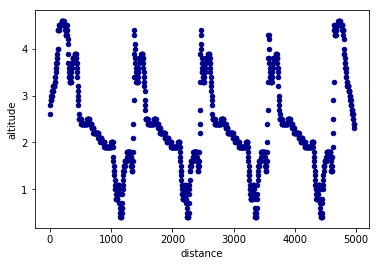

In [79]:
#plot altitude vs distance - explain the differences with the previous plot
s.plot.scatter(x='distance',y='altitude',c='DarkBlue')

## Visualizing using Plotly and Plotly Express

Plotly is a well known open source library for visualization that can used quite easily in notebooks such as this one. In the Spring of 2019, Plotly Express [was announced](https://medium.com/plotly/introducing-plotly-express-808df010143d) -   a terse, consistent, high-level API for rapid data exploration and figure generation (in other words: many of the visualizations required can be created with Plotly Express (while leveraging all of Plotly) in just a few lines of code).

In this notebook, I am using Plotly 4.1 (https://plot.ly/python/getting-started/) - which by default is off line and includes plotly express.

If you do no know Plotly yet, please read [this article](https://towardsdatascience.com/the-next-level-of-data-visualization-in-python-dd6e99039d5e) by Will Koehrsen who declares his love for Plotly in a moving and convincing way.

In [80]:
# Using Conda for the installation:
# conda install -c plotly plotly=4.1.0
# conda install -c plotly chart-studio=1.0.0

# Next, these imports and initializations are required to load plotly and cufflinks and to use plotly locally.

import plotly.graph_objs as go
import plotly.express as px
from chart_studio.plotly import plot, iplot

The next plot shows altitude vs distance. Spot the Col du Tourmalet... (well, try not too hard as it is not there; the total highest elevation is only four meters over sea level. Yet, it is enough to find the repeating pattern - in this case the same stretch we were walking several times.

In [81]:
fig = px.line(s, x="distance", y="altitude", title='Altitude vs Distance in our Walk Around the Fort', render_mode='svg')
fig.show()